## In this notebook I'm looking at addition within the attention layers.

In particular, a network needs to be able to add numbers with large number of digits, when its vocabulary only contains the individual digits (or collections of subdigits). Here I use two stacked attention layers

In this notebook we test it by having a vocabulary just of digits (1-9), and summing three-digit numbers. Thus it has to learn to carry over. Right now the minimum value of the three digit numbers is 500 and the max is 999, thus, every sum creates a 4 digit number.

Examples in the test set are not contained in the train set.

Other things i implemented, but couldnt get something properly training...
- min_val being between 100-500, then the result couyld actually be three digits
- min_val being a 1 or 2 digit number as this is a more interesting case where the "+" and "=" signs are in different places





As a side note, it would be interesting to see what token GPT2 uses to sum (100 + 101). I.e, does it use the '1' and '0' tokens, or does it also use the '10' token?

In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from models import *
from inspection import *
device = "cuda" if t.cuda.is_available() else "cpu"


In [2]:
dataset = AdditionDataset(n_samples=10240, min_val = 500, max_val = 999, no_test_examples=512)#, no_digits_to_predict = 2)
for i in range(3): print(''.join(dataset.idx_to_str(dataset[i][0])),' answer: ',  ''.join(dataset.idx_to_str(dataset[i][1])))

# Hyperparameter
batch_size = 128

# Dataset
vocab_size = len(dataset.vocab)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
model = StackedAttentionModel(vocab_size=vocab_size, num_layers= 2, nhead=2, d_model=16).to(device)

895+507=  answer:  1402
545+987=  answer:  1532
901+903=  answer:  1804


In [3]:
test_performance_by_input_format(model, dataset)
print('\n\n')
test_performance_by_output_format(model, dataset)


Format               Count    Correct    Accuracy  
triple+triple        512      0            0.00%

Overall              512      0            0.00%



Output Format        Count    Correct    Accuracy  
four_digit_sum       512      0            0.00%


In [4]:
loss_store = {'train_loss' : [], 'test_loss' : [], 'test_logits' : [], 'test_accuracy': [], 'attentions': []}


In [5]:

lr = 1e-3
epochs = 400
optimizer = t.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()#ignore_index=dataset.vocab['<PAD>'])


progress_bar = tqdm(range(epochs))
# Training
for epoch in progress_bar:
    model.train()
    dataset.train = True
    total_loss = 0
    for inp, target in dataloader:
        inp = inp.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(inp)

        logits_out = logits[:, -dataset.max_output_len:, :]   
        loss = criterion(
            logits_out.reshape(-1, vocab_size),   # flatten batch & positions
            target.reshape(-1))
    
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)

    model.eval()
    dataset.train = False
    with t.no_grad():
        total_test_loss = 0
        total_correct = 0
        for inp, target in dataloader:
            inp = inp.to(device)
            target = target.to(device)

            logits = model(inp)
            logits_out = logits[:, -dataset.max_output_len:, :]   # predict only the output part
            loss = criterion(
                logits_out.reshape(-1, vocab_size),
                target.reshape(-1)
            )
            total_test_loss += loss.item()

            # Calculate accuracy
            predictions = t.argmax(logits_out, dim=-1)
            total_correct += (predictions == target).all(dim=1).sum().item()

        attentions = calculate_manual_attention(model, inp[:1], layer_index=0)
        error = total_test_loss / len(dataloader)
        accuracy = total_correct / len(dataset)

    progress_bar.set_description(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}, Test Loss: {error:.4f}, Test Acc: {accuracy:.4f}")
    loss_store['train_loss'].append(avg_loss)
    loss_store['test_loss'].append(error)

    loss_store['test_logits'].append(logits_out.cpu().numpy())
    loss_store['test_accuracy'].append(accuracy)
    loss_store['attentions'].append(attentions)

Epoch 400/400 | Loss: 0.0037, Test Loss: 0.0034, Test Acc: 0.9961: 100%|██████████| 400/400 [05:00<00:00,  1.33it/s]


/var/folders/5n/1bb64ttd06d_xd1khh6hq6x80000gn/T/ipykernel_17213/2789071312.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  logits_over_time = t.tensor(loss_store['test_logits']) # shape [epochs, batch, seq_len, vocab]


Truth:  962+538= 1500 ||| Predicted: 1500


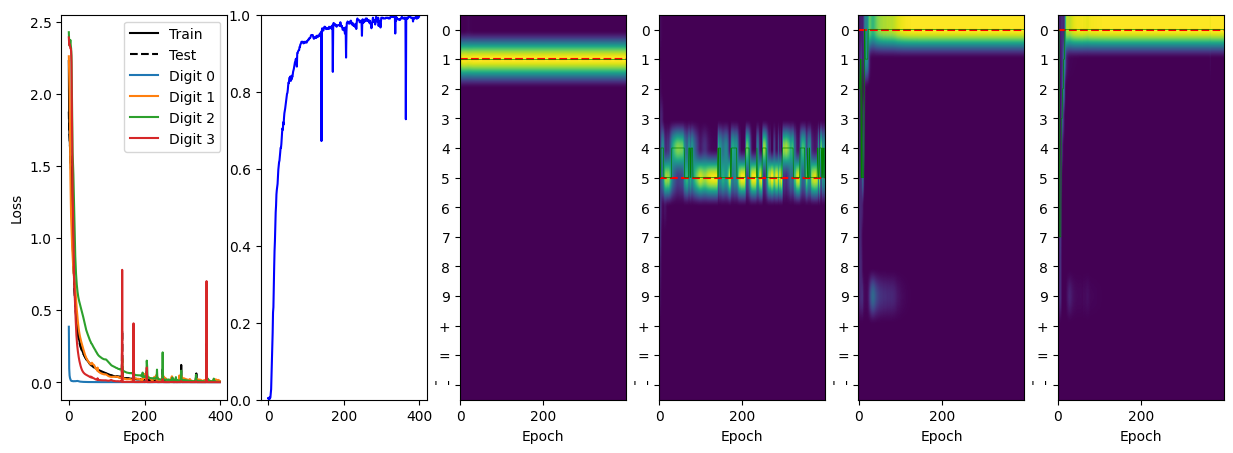

In [6]:
fig, ax = plt.subplots(1, dataset.max_output_len + 2, figsize=(15,5))

ax[0].plot(loss_store['train_loss'],'k', label="Train")
ax[0].plot(loss_store['test_loss'], 'k--', label="Test")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

data_example = t.randint(len(loss_store['test_logits'][0]),(1,)).item()

logits_over_time = t.tensor(loss_store['test_logits']) # shape [epochs, batch, seq_len, vocab]
probs_out = t.softmax(logits_over_time[:,data_example], dim=-1)   # shape [batch, 2, vocab]

epochs = len(logits_over_time)

CE_per_epoch = []
for i in range(epochs):
    for seq_idx in range(dataset.max_output_len):
        CE_per_epoch.append(criterion(logits_over_time[i, :,seq_idx, :].reshape(-1, vocab_size), target[:, seq_idx].reshape(-1)).item())
CE_per_epoch = t.tensor(CE_per_epoch).reshape(epochs, dataset.max_output_len)

for i in range(dataset.max_output_len):
    ax[0].plot(CE_per_epoch[:,i], label=f"Digit {i}")
ax[0].legend()

ax[1].plot(loss_store['test_accuracy'], 'b', label="Test Accuracy"); ax[1].set_ylim(0,1)

for i in range(2, dataset.max_output_len + 2): 
    ax[i].imshow(probs_out[:,i-2,:].T, aspect='auto')
    ax[i].set_yticks(t.arange(13))
    ax[i].set_yticklabels([str(x) for x in range(10)] + ["+", "=", "'  '"])
    ax[i].set_xlabel("Epoch")
    target_num = target[data_example][i-2].item()
    ax[i].plot(target_num*t.ones(epochs), 'r--', label="Correct")
    ax[i].plot(probs_out[:,i-2,:].argmax(dim=-1).cpu(), 'g-', linewidth=.5, label="Predicted")

pred_str = ''.join(dataset.idx_to_str(probs_out[-1, :, :].argmax(dim=-1)))

print("Truth: ", ''.join(dataset.idx_to_str(inp[data_example])), ''.join(dataset.idx_to_str(target[data_example])), '||| Predicted:', pred_str)


In [7]:
test_performance_by_input_format(model, dataset)
print("\n\n")
test_performance_by_output_format(model, dataset)


Format               Count    Correct    Accuracy  
triple+triple        512      510         99.61%

Overall              512      510         99.61%



Output Format        Count    Correct    Accuracy  
four_digit_sum       512      510         99.61%


Now interp...

In [8]:
inspect_weights(model)
activations = extract_activations(model, inp)
attentions = calculate_manual_attention(model, inp, layer_index=0)
# attentions1 = calculate_manual_attention(model, inp, layer_index=1)

embedding_mats = extract_io_matrices(model)
attention0_mats = extract_attention_matrices(model, layer_index=0)

Name: embed.weight                   | Shape: [13, 16]             | Device: cpu
Name: pos_embed.weight               | Shape: [10, 16]             | Device: cpu
Name: layers.0.attn.in_proj_weight   | Shape: [48, 16]             | Device: cpu
Name: layers.0.attn.in_proj_bias     | Shape: [48]                 | Device: cpu
Name: layers.0.attn.out_proj.weight  | Shape: [16, 16]             | Device: cpu
Name: layers.0.attn.out_proj.bias    | Shape: [16]                 | Device: cpu
Name: layers.0.ln.weight             | Shape: [16]                 | Device: cpu
Name: layers.0.ln.bias               | Shape: [16]                 | Device: cpu
Name: layers.1.attn.in_proj_weight   | Shape: [48, 16]             | Device: cpu
Name: layers.1.attn.in_proj_bias     | Shape: [48]                 | Device: cpu
Name: layers.1.attn.out_proj.weight  | Shape: [16, 16]             | Device: cpu
Name: layers.1.attn.out_proj.bias    | Shape: [16]                 | Device: cpu
Name: layers.1.ln.weight    

## First lets look at the embedding output for some basic example

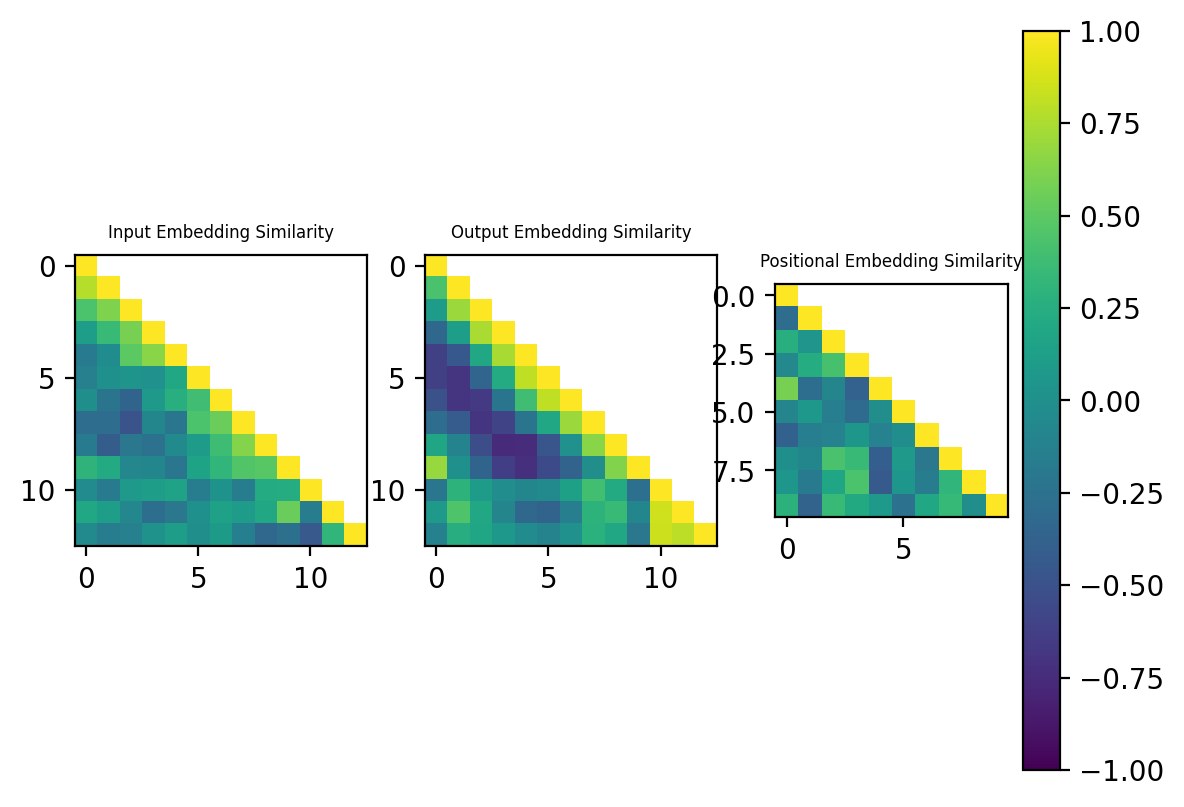

In [9]:
We = embedding_mats['W_Embed'].detach()
Wo = embedding_mats['W_Out'].detach()
Wp = embedding_mats['W_Pos'].detach()

simse = t.tensor([[t.cosine_similarity(We[i], We[j], dim=-1) if (i <= j) else t.nan for i in range(len(We))] for j in range(len(We))])
simso = t.tensor([[t.cosine_similarity(Wo[i], Wo[j], dim=-1) if (i <= j) else t.nan for i in range(len(Wo))] for j in range(len(Wo))])
simsp = t.tensor([[t.cosine_similarity(Wp[i], Wp[j], dim=-1) if (i <= j) else t.nan for i in range(len(Wp))] for j in range(len(Wp))])

fig,ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(simse, vmax=1, vmin=-1); ax[0].set_title("Input Embedding Similarity", fontsize = 6)
ax[1].imshow(simso, vmax=1, vmin=-1); ax[1].set_title("Output Embedding Similarity", fontsize = 6)
a = ax[2].imshow(simsp, vmax=1, vmin=-1); ax[2].set_title("Positional Embedding Similarity", fontsize = 6)
fig.colorbar(a, ax=ax[2])

In [10]:
def analyze_att_maps(model, dataset, test_cases):    
    # Test various formats
    
    fig, axes = plt.subplots(len(test_cases), len(model.layers), figsize=(8, 2*len(test_cases)), squeeze=False)
    
    for case_idx, (a, b) in enumerate(test_cases):
        inp_tensor, out = dataset.get_example(a, b)
        # Get attention from both layers
        with t.no_grad():
            seq_len = inp_tensor.size(1)
            positions = t.arange(seq_len, device=inp_tensor.device).unsqueeze(0)
            x = model.embed(inp_tensor) + model.pos_embed(positions)
            
            for layer_idx, layer in enumerate(model.layers):
                x, attn_weights = layer(x)
                # attn_weights: [batch, seq_len, seq_len] (averaged over heads)
                pattern = attn_weights[0].cpu().numpy()
                
                ax = axes[case_idx, layer_idx]
                im = ax.imshow(pattern, cmap='viridis', aspect='auto')
                ax.set_title(f'{a}+{b}={a+b}, Layer {layer_idx}')
                ax.set_xlabel('Key position')
                ax.set_ylabel('Query position')
                
                # Mark special tokens
                inp = inp_tensor[0]
                labels = dataset.idx_to_str(inp)
                ax.set_xticks(range(len(inp)))
                ax.set_xticklabels(labels[:len(inp)])
                ax.set_yticks(range(len(inp)))
                ax.set_yticklabels(labels[:len(inp)])
                plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()



okay ive done a few more test cases. For layer 1, I see that the + query and a2 are attending for examples that are like "a1 a2 + b1=". And in examples that are "a1 a2 + b1 b2 =", the + query is with a2 and b2

however, for "a1 + b1 =", there is no obvious pattern like that. Instead the second digit just attends to itself mainly

and for the "a1 + b1 b2 = ", its a similar story. especially a1 doesnt attend to anything. but + and = attend a bit


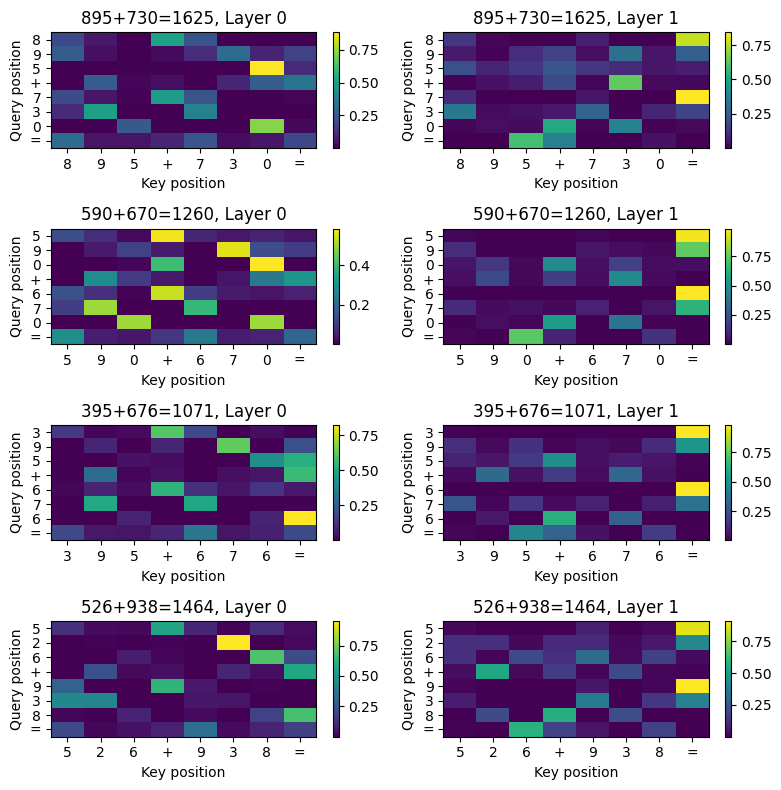

In [11]:
test_cases = [
        (895, 730),  
        (590, 670),   
        (395, 676),  # Double + Double
        (526, 938)  # Double + Double
    ]
analyze_att_maps(model, dataset, test_cases)

In [12]:
def decompose_computation(model, dataset, a, b):
    """See where in the model the answer emerges"""
    
    inp, out = dataset.encode_pair(a, b)
    inp_indices = [dataset.vocab[x] for x in inp]
    inp_indices += [dataset.vocab['<PAD>']] * (dataset.max_input_len - len(inp_indices))
    inp_tensor = t.tensor([inp_indices], device=device)
    
    print(f"\n{'='*70}")
    print(f"Decomposing: {a} + {b} = {a+b}")
    print('='*70)
    
    with t.no_grad():
        seq_len = inp_tensor.size(1)
        positions = t.arange(seq_len, device=inp_tensor.device).unsqueeze(0)
        
        # Stage 0: Just embeddings
        x = model.embed(inp_tensor) + model.pos_embed(positions)
        logits_0 = model.out(x)
        probs_0 = t.softmax(logits_0[0, -dataset.max_output_len:, :], dim=-1)
        pred_0 = logits_0[0, -dataset.max_output_len:, :].argmax(dim=-1)
        pred_str_0 = ''.join([str(list(dataset.vocab)[p]) for p in pred_0])
        
        print(f"\nAfter embeddings only:")
        print(f"  Prediction: {pred_str_0}")
        print(f"  Confidence: {probs_0.max(dim=-1)[0].mean().item():.3f}")
        
        # Stage 1: After first attention layer
        x, attn_1 = model.layers[0](x)
        logits_1 = model.out(x)
        probs_1 = t.softmax(logits_1[0, -dataset.max_output_len:, :], dim=-1)
        pred_1 = logits_1[0, -dataset.max_output_len:, :].argmax(dim=-1)
        pred_str_1 = ''.join([str(list(dataset.vocab)[p]) for p in pred_1])
        
        print(f"\nAfter Layer 0:")
        print(f"  Prediction: {pred_str_1}")
        print(f"  Confidence: {probs_1.max(dim=-1)[0].mean().item():.3f}")
        print(f"  Attention entropy: {-(attn_1[0] * t.log(attn_1[0] + 1e-10)).sum(dim=-1).mean().item():.3f}")
        
        # Stage 2: After second attention layer
        x, attn_2 = model.layers[1](x)
        logits_2 = model.out(x)
        probs_2 = t.softmax(logits_2[0, -dataset.max_output_len:, :], dim=-1)
        pred_2 = logits_2[0, -dataset.max_output_len:, :].argmax(dim=-1)
        pred_str_2 = ''.join([str(list(dataset.vocab)[p]) for p in pred_2])
        
        print(f"\nAfter Layer 1 (final):")
        print(f"  Prediction: {pred_str_2} {'✓' if pred_str_2 == str(a+b) else '✗'}")
        print(f"  Confidence: {probs_2.max(dim=-1)[0].mean().item():.3f}")
        print(f"  Attention entropy: {-(attn_2[0] * t.log(attn_2[0] + 1e-10)).sum(dim=-1).mean().item():.3f}")
        
        # Check how much each layer changed the prediction
        print(f"\nChanges:")
        print(f"  Embeddings → Layer 0: {pred_str_0} → {pred_str_1}")
        print(f"  Layer 0 → Layer 1: {pred_str_1} → {pred_str_2}")

# Test on several examples
for a, b in test_cases:
    decompose_computation(model, dataset, a, b)


Decomposing: 895 + 730 = 1625

After embeddings only:
  Prediction: 1589
  Confidence: 0.804

After Layer 0:
  Prediction: 1989
  Confidence: 0.688
  Attention entropy: 1.194

After Layer 1 (final):
  Prediction: 1625 ✓
  Confidence: 1.000
  Attention entropy: 1.231

Changes:
  Embeddings → Layer 0: 1589 → 1989
  Layer 0 → Layer 1: 1989 → 1625

Decomposing: 590 + 670 = 1260

After embeddings only:
  Prediction: 1589
  Confidence: 0.697

After Layer 0:
  Prediction: 1909
  Confidence: 0.674
  Attention entropy: 1.256

After Layer 1 (final):
  Prediction: 1260 ✓
  Confidence: 1.000
  Attention entropy: 0.919

Changes:
  Embeddings → Layer 0: 1589 → 1909
  Layer 0 → Layer 1: 1909 → 1260

Decomposing: 395 + 676 = 1071

After embeddings only:
  Prediction: 1509
  Confidence: 0.701

After Layer 0:
  Prediction: 1989
  Confidence: 0.817
  Attention entropy: 1.137

After Layer 1 (final):
  Prediction: 1471 ✗
  Confidence: 0.998
  Attention entropy: 1.081

Changes:
  Embeddings → Layer 0: 1509

Analyse circuits

In [13]:
def extract_weight_matrices(model):
    """Extract all the key weight matrices from the model"""
    
    # Embedding matrices
    W_embed = model.embed.weight  # [vocab_size, d_model]
    W_pos = model.pos_embed.weight  # [max_seq_len, d_model]
    
    # Output (unembedding) matrix
    W_out = model.out.weight  # [vocab_size, d_model]
    
    # Attention matrices for each layer
    attn_matrices = []
    
    for layer_idx, layer in enumerate(model.layers):
        attn_module = layer.attn
        
        # Get QKV projection matrix
        W_qkv = attn_module.in_proj_weight  # [3*d_model, d_model]
        d_model = W_embed.size(1)
        
        # Split into Q, K, V
        W_Q = W_qkv[:d_model, :]      # [d_model, d_model]
        W_K = W_qkv[d_model:2*d_model, :]
        W_V = W_qkv[2*d_model:, :]
        
        # Output projection
        W_O = attn_module.out_proj.weight  # [d_model, d_model]
        
        attn_matrices.append({
            'W_Q': W_Q,
            'W_K': W_K,
            'W_V': W_V,
            'W_O': W_O,
            'layer_idx': layer_idx
        })
    
    return {
        'W_embed': W_embed,
        'W_pos': W_pos,
        'W_out': W_out,
        'attn_layers': attn_matrices,
        'd_model': d_model
    }

weights = extract_weight_matrices(model)
print(f"Embedding: {weights['W_embed'].shape}")
print(f"Positional: {weights['W_pos'].shape}")
print(f"Output: {weights['W_out'].shape}")
print(f"Number of layers: {len(weights['attn_layers'])}")

Embedding: torch.Size([13, 16])
Positional: torch.Size([10, 16])
Output: torch.Size([13, 16])
Number of layers: 2
